In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [2]:
def gpu_setup():
    """Setup the available GPUs to be used for training."""
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Specify GPU to restrict usage below
        tf.config.set_visible_devices(physical_devices[1], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        # Logical device was not created for first GPU
        assert len(logical_devices) == len(physical_devices) - 1
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass


def mixed_precision_setup():
    """Setup support for mixed precision training."""
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)

gpu_setup()
mixed_precision_setup()

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Data

In [3]:
seed = 0
data_dir = 'data'
image_shape = (512, 384, 3)

batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=seed,
    image_size=image_shape[:-1],
    batch_size=batch_size
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_shape[:-1],
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 2527 files belonging to 6 classes.
Using 2275 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
6 classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).cache().prefetch(buffer_size=AUTOTUNE)

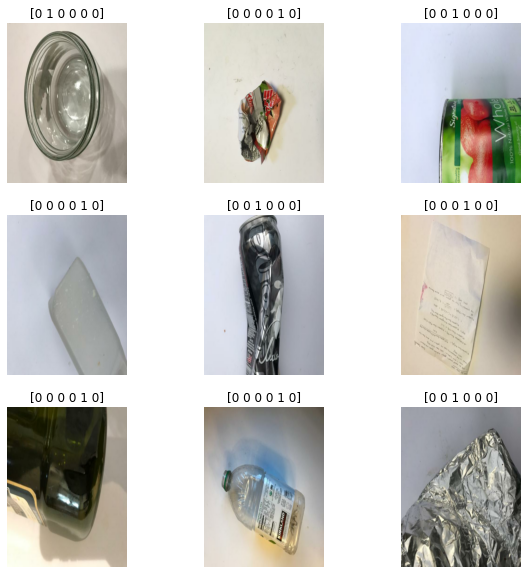

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype("uint8"))
        plt.axis("off")

# Model

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

prediction_layer = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, name='logits'),
    tf.keras.layers.Activation('softmax', dtype='float32', name='probs'), # separate actf to support mixed precision
], name='prediction')

inputs = tf.keras.Input(shape=image_shape)
x = base_model(inputs, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 384, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 12, 1280)      2257984   
_________________________________________________________________
prediction (Sequential)      (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
num_epochs = 50
initial_epoch = 0

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.1
    ),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    initial_epoch=initial_epoch,
    epochs=num_epochs,
)

Epoch 1/50
72/72 [==============================] - 15s 213ms/step - loss: 1.5144 - accuracy: 0.4356 - val_loss: 1.2720 - val_accuracy: 0.5782
Epoch 2/50
72/72 [==============================] - 4s 56ms/step - loss: 1.2884 - accuracy: 0.5582 - val_loss: 1.1818 - val_accuracy: 0.6257
Epoch 3/50
72/72 [==============================] - 4s 59ms/step - loss: 1.2242 - accuracy: 0.5978 - val_loss: 1.1304 - val_accuracy: 0.6515
Epoch 4/50
72/72 [==============================] - 4s 57ms/step - loss: 1.1756 - accuracy: 0.6321 - val_loss: 1.0927 - val_accuracy: 0.6851
Epoch 5/50
72/72 [==============================] - 5s 69ms/step - loss: 1.1434 - accuracy: 0.6541 - val_loss: 1.0661 - val_accuracy: 0.6970
Epoch 6/50
72/72 [==============================] - 5s 73ms/step - loss: 1.1158 - accuracy: 0.6593 - val_loss: 1.0428 - val_accuracy: 0.7129
Epoch 7/50
72/72 [==============================] - 5s 74ms/step - loss: 1.0867 - accuracy: 0.6840 - val_loss: 1.0289 - val_accuracy: 0.7208
Epoch 8/50


In [8]:
save_path = os.path.join('model', 'mobilenetv2', '1', 'saved_model') # model name, version
tf.saved_model.save(model, save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mobilenetv2/1/assets
